In [208]:
import numpy as np
import pandas as pd
import requests
import json 
from tqdm import tqdm
import pickle
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, QuantileTransformer, PowerTransformer

import matplotlib.pyplot as plt
import sklearn
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from tqdm import tqdm

import random
from xgboost import XGBClassifier, XGBRegressor, plot_importance, plot_tree
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from scipy import integrate

from mpl_toolkits.basemap import Basemap

In [209]:
contacts = pd.read_csv('C:\\Users\\mznid\\Downloads\\datasets\\Marketing_Analytics_Datasets\\DMEFExtractContactsV01.CSV')

customers = pd.read_csv('C:\\Users\\mznid\\Downloads\\datasets\\Marketing_Analytics_Datasets\\DMEFExtractSummaryV01.CSV')

orders = pd.read_csv('C:\\Users\\mznid\\Downloads\\datasets\\Marketing_Analytics_Datasets\\DMEFExtractLinesV01.CSV')

contacts = pd.read_csv('C:\\Users\\mznid\\Downloads\\datasets\\Marketing_Analytics_Datasets\\DMEFExtractContactsV01.CSV')

In [210]:
contactsaggregate = contacts.groupby(['Cust_ID','ContactType']).count().reset_index()

print(contactsaggregate)

         Cust_ID ContactType  ContactDate
0          22120           C           21
1          24436           C            1
2          24436           E          123
3          29278           C            9
4          50011           E          119
...          ...         ...          ...
103210  91216829           E            1
103211  91217064           E            1
103212  91218539           E            1
103213  91222126           E            1
103214  91223018           E            1

[103215 rows x 3 columns]


In [211]:
droplist = []
for ind1, each in contactsaggregate.iterrows():
    for ind2, every in enumerate(each):
        if every == ' ':
            droplist.append(ind1)

keeplist = list(set(list(range(0, len(contactsaggregate.iloc[:,0])))) - set(droplist))

In [212]:
contactsaggregateNONULLS = contactsaggregate.iloc[keeplist,:]

# losing about 40000 rows of order granularity

contactsaggregateNONULLS.sort_values(by=['Cust_ID'], ascending = True)

,Cust_ID,ContactType,ContactDate
0,22120,C,21
1,24436,C,1
2,24436,E,123
3,29278,C,9
4,50011,E,119
...,...,...,...
103210,91216829,E,1
103211,91217064,E,1
103212,91218539,E,1
103213,91222126,E,1


In [213]:
contactcustomerlist = list(set(contactsaggregateNONULLS.loc[:,'Cust_ID']))
contactcustomerlist

[90701829,
 44302344,
 78381065,
 88080399,
 67633169,
 83099665,
 85983252,
 54788129,
 69206055,
 81526823,
 58196009,
 88080424,
 81788974,
 38535218,
 81526835,
 71303221,
 68943931,
 71041084,
 81002557,
 75235395,
 35389511,
 53477448,
 54788168,
 58982471,
 83099719,
 74711128,
 81526872,
 65011806,
 39321699,
 72876137,
 31719531,
 62390387,
 64749685,
 62128246,
 68943993,
 88080510,
 70779007,
 44040322,
 74711173,
 70254733,
 39583886,
 32768143,
 70254736,
 50069655,
 80740503,
 82051224,
 83099803,
 67109021,
 62914726,
 84672679,
 87818409,
 79954091,
 81002667,
 67633327,
 89391280,
 74973364,
 79954103,
 78905532,
 59769028,
 87294151,
 36176073,
 43778253,
 69206227,
 89653467,
 73924830,
 84934878,
 66060514,
 63176933,
 76546277,
 84672743,
 80478440,
 36438250,
 89391338,
 56361198,
 64225521,
 88080637,
 76546304,
 79429888,
 88080642,
 52953347,
 61866249,
 87818514,
 71565587,
 47448340,
 81527068,
 78905635,
 74187048,
 72876330,
 80740651,
 79692077,
 43516216,

In [214]:
customerdict = {'Cust_ID':[],'CATALOGoutreach':[],'EMAILoutreach':[]}

for each in tqdm(contactcustomerlist):
    subset = contactsaggregateNONULLS.loc[contactsaggregateNONULLS.Cust_ID == each,:].reset_index()
    
    C = 0
    E = 0
    
    if len(subset.iloc[:,0]) > 0:
        for every in range(0,len(subset.iloc[:,0])):
            if subset.loc[every,'ContactType'] == 'C':
                C = subset.loc[every,'ContactDate']
            elif subset.loc[every,'ContactType'] == 'E':
                E = subset.loc[every,'ContactDate']
        
        customerdict['Cust_ID'] += [subset.loc[0,'Cust_ID']]
        customerdict['CATALOGoutreach'] += [C]
        customerdict['EMAILoutreach'] += [E]

        
newdf = pd.DataFrame(customerdict)

newdf

100%|███████████████████████████████████████████████████████████████████████████| 80421/80421 [01:30<00:00, 893.35it/s]


,Cust_ID,CATALOGoutreach,EMAILoutreach
0,90701829,0,3
1,44302344,40,129
2,78381065,8,0
3,88080399,2,9
4,67633169,22,0
...,...,...,...
80416,61603819,1,0
80417,81526772,1,0
80418,63700985,8,0
80419,54001660,33,0


In [215]:
for ind, each in customers.iterrows():
    try:
        if float(customers.loc[ind,'SCF_Code']) < 100.:
            customers.loc[ind, 'SCF_Code'] = '0' + str(customers.loc[ind,'SCF_Code'])
    except:
        pass

In [216]:
customers = customers.loc[:,[
    'Cust_ID',
    'FirstChannel', 'FirstDollar'
    ,'SCF_Code'
    ,'FirstYYMM'
    ,'StoreDist'
    ,'AcqDate'
    
    ,'Email'
    
    ,'Sewing','Travel','Hunting','FineArts','CarOwner','Collect','Needle','DogOwner','Cooking','CurrAff','CurrEv','Pets','Fashion','Camping','Boating', 'Wines', 'Exercise','SelfHelp'
    
    
    
    
    
    #,'Child0_2','Child3_5','Child6_11','Child12_16','Child17_18'
    

    
    ,'RetF07Dollars','RetS07Dollars','RetF06Dollars','RetS06Dollars','RetF05Dollars','RetS05Dollars','RetF04Dollars','RetS04Dollars','RetPre04Dollars'
    ,'RetF07Trips','RetS07Trips','RetF06Trips','RetS06Trips','RetF05Trips','RetS05Trips','RetF04Trips','RetS04Trips','RetPre04Trips'
    ,'RetF07Lines','RetS07Lines','RetF06Lines','RetS06Lines','RetF05Lines','RetS05Lines','RetF04Lines','RetS04Lines','RetPre04Lines'
    
    ,'IntF07GDollars','IntS07GDollars','IntF06GDollars','IntS06GDollars','IntF05GDollars','IntS05GDollars','IntF04GDollars','IntS04GDollars','IntPre04GDollars'
    ,'IntF07NGDollars','IntS07NGDollars','IntF06NGDollars','IntS06NGDollars','IntF05NGDollars','IntS05NGDollars','IntF04NGDollars','IntS04NGDollars','IntPre04NGDollars'
    ,'IntF07Orders','IntS07Orders','IntF06Orders','IntS06Orders','IntF05Orders','IntS05Orders','IntF04Orders','IntS04Orders','IntPre04Orders'
    ,'IntF07Lines','IntS07Lines','IntF06Lines','IntS06Lines','IntF05Lines','IntS05Lines','IntF04Lines','IntS04Lines','IntPre04Lines'
    
    ,'CatF07GDollars','CatS07GDollars','CatF06GDollars','CatS06GDollars','CatF05GDollars','CatS05GDollars','CatF04GDollars','CatS04GDollars','CatPre04GDollars'
    ,'CatF07NGDollars','CatS07NGDollars','CatF06NGDollars','CatS06NGDollars','CatF05NGDollars','CatS05NGDollars','CatF04NGDollars','CatS04NGDollars','CatPre04NGDollars'
    ,'CatF07Orders','CatS07Orders','CatF06Orders','CatS06Orders','CatF05Orders','CatS05Orders','CatF04Orders','CatS04Orders','CatPre04Orders'
    ,'CatF07Lines','CatS07Lines','CatF06Lines','CatS06Lines','CatF05Lines','CatS05Lines','CatF04Lines','CatS04Lines','CatPre04Lines'
    
    ]]

In [219]:

droplist = []

for ind1, each in customers.iterrows():
    for ind2, every in enumerate(each):
        if every == ' ':
            droplist.append(ind1)

keeplist = list(set(list(range(0, len(customers.iloc[:,0])))) - set(droplist))


In [220]:
customersfeatures = customers.iloc[keeplist,:]

In [163]:
def convertYNtoBinary(df, column):
    temp = []
    for each in df.loc[:,column]:
        if each == 'Y':
            temp.append(1)
        else:
            temp.append(0)
    #print(len(temp))
    df.loc[:,column] = pd.Series(temp, index = df.index)


for col in ['Email','Sewing','Travel','Hunting','FineArts','CarOwner','Collect','Needle','DogOwner','Cooking','CurrAff','CurrEv','Pets','Fashion'
            ,'Camping','Boating', 'Wines', 'Exercise','SelfHelp']: # ,'Child0_2','Child3_5','Child6_11','Child12_16','Child17_18'
    convertYNtoBinary(customersfeatures, col)

C:\Users\mznid\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [97]:
# I'VE PICKLED A DICTIONARY THAT WILL HELP CONVERT SCF_Code to GPS COORDINATES. THIS TOOK A LOT OF OBNOXIOUS WORK AND API STUFF SO I'VE EXCLUDED THAT PART OF THE CODE. 
SCFcoordinates = pickle.load( open( "C:\\Users\\mznid\\SCFcoordinates.p", "rb" ) )

In [98]:
'''
gpsx = []
gpsy = []
for each in customersfeatures.loc[:,'SCF_Code']:
    if type(SCFcoordinates[each]) == float:        # checks for NaNs, a few SCF_Codes didn't have addresses and so were assigned NaN coordinates. we could fix this manually if we want
        gpsx.append(SCFcoordinates[each])
        gpsy.append(SCFcoordinates[each])
    else:
        gpsx.append(SCFcoordinates[each]['results'][0]['geometry']['viewport']['northeast']['lng'])          # northeast or southwest????
        gpsy.append(SCFcoordinates[each]['results'][0]['geometry']['viewport']['northeast']['lat'])    

customersfeatures.loc[:,'gpsX'] = pd.Series(gpsx, index = customersfeatures.index)
customersfeatures.loc[:,'gpsY'] = pd.Series(gpsy, index = customersfeatures.index)

customersfeatures = customersfeatures.drop(columns = ['SCF_Code'])
'''

"\ngpsx = []\ngpsy = []\nfor each in customersfeatures.loc[:,'SCF_Code']:\n    if type(SCFcoordinates[each]) == float:        # checks for NaNs, a few SCF_Codes didn't have addresses and so were assigned NaN coordinates. we could fix this manually if we want\n        gpsx.append(SCFcoordinates[each])\n        gpsy.append(SCFcoordinates[each])\n    else:\n        gpsx.append(SCFcoordinates[each]['results'][0]['geometry']['viewport']['northeast']['lng'])          # northeast or southwest????\n        gpsy.append(SCFcoordinates[each]['results'][0]['geometry']['viewport']['northeast']['lat'])    \n\ncustomersfeatures.loc[:,'gpsX'] = pd.Series(gpsx, index = customersfeatures.index)\ncustomersfeatures.loc[:,'gpsY'] = pd.Series(gpsy, index = customersfeatures.index)\n\ncustomersfeatures = customersfeatures.drop(columns = ['SCF_Code'])\n"

In [99]:
customersfeatures = customersfeatures.dropna()

In [204]:
iddict = {}
for each in customersfeatures.loc[:,'FirstChannel']:
    if each not in iddict:
        iddict[each] = len(iddict)

verification_status = [iddict[i] for i in customersfeatures.loc[:,'FirstChannel']]

inverseiddict = dict(map(reversed, iddict.items()))

verification_statusdf = pd.DataFrame(to_categorical(verification_status), columns = [inverseiddict[0],inverseiddict[1],inverseiddict[2]], index = customersfeatures.index)

customersfeatures = customersfeatures.drop(columns=['FirstChannel'])

KeyError: 'FirstChannel'

In [221]:
FirstInYears = []
for each in customersfeatures.loc[:,'FirstYYMM']:
    temp = int(str(each)[:4]) + ((int(str(each)[-2:]) - 1) / 12)
    FirstInYears.append(temp)

customersfeatures.loc[:,'FirstYYMM'] = pd.Series(FirstInYears, index = customersfeatures.index)

In [222]:
AcqDateInYears = []
for each in customersfeatures.loc[:,'AcqDate']:
    temp = int(str(each)[:4]) + ((int(str(each)[-2:]) - 1) / 12)
    AcqDateInYears.append(temp)

customersfeatures.loc[:,'AcqDate'] = pd.Series(AcqDateInYears, index = customersfeatures.index)

In [223]:
# loc works different from iloc... passing an integer to index will look for the index name, not position, so resent index:
customersfeatures = customersfeatures.reset_index()



RETAILdollarstotal = customersfeatures.loc[:,['RetF07Dollars','RetS07Dollars','RetF06Dollars','RetS06Dollars','RetF05Dollars','RetS05Dollars','RetF04Dollars','RetS04Dollars','RetPre04Dollars']].sum(axis=1)
INTERNETdollarstotal = customersfeatures.loc[:,['IntF07GDollars','IntS07GDollars','IntF06GDollars','IntS06GDollars','IntF05GDollars','IntS05GDollars','IntF04GDollars','IntS04GDollars','IntPre04GDollars','IntF07NGDollars','IntS07NGDollars','IntF06NGDollars','IntS06NGDollars','IntF05NGDollars','IntS05NGDollars','IntF04NGDollars','IntS04NGDollars','IntPre04NGDollars']].sum(axis=1)
CATALOGdollarstotal = customersfeatures.loc[:,['CatF07GDollars','CatS07GDollars','CatF06GDollars','CatS06GDollars','CatF05GDollars','CatS05GDollars','CatF04GDollars','CatS04GDollars','CatPre04GDollars','CatF07NGDollars','CatS07NGDollars','CatF06NGDollars','CatS06NGDollars','CatF05NGDollars','CatS05NGDollars','CatF04NGDollars','CatS04NGDollars','CatPre04NGDollars']].sum(axis=1)


RETAILtripstotal = customersfeatures.loc[:,['RetF07Trips','RetS07Trips','RetF06Trips','RetS06Trips','RetF05Trips','RetS05Trips','RetF04Trips','RetS04Trips','RetPre04Trips']].sum(axis=1)
INTERNETorderstotal = customersfeatures.loc[:,['IntF07Orders','IntS07Orders','IntF06Orders','IntS06Orders','IntF05Orders','IntS05Orders','IntF04Orders','IntS04Orders','IntPre04Orders']].sum(axis=1)
CATALOGorderstotal = customersfeatures.loc[:,['CatF07Orders','CatS07Orders','CatF06Orders','CatS06Orders','CatF05Orders','CatS05Orders','CatF04Orders','CatS04Orders','CatPre04Orders']].sum(axis=1)


RETAILitemstotal = customersfeatures.loc[:,['RetF07Lines','RetS07Lines','RetF06Lines','RetS06Lines','RetF05Lines','RetS05Lines','RetF04Lines','RetS04Lines','RetPre04Lines']].sum(axis=1)
INTERNETitemstotal = customersfeatures.loc[:,['IntF07Lines','IntS07Lines','IntF06Lines','IntS06Lines','IntF05Lines','IntS05Lines','IntF04Lines','IntS04Lines','IntPre04Lines']].sum(axis=1)
CATALOGitemstotal = customersfeatures.loc[:,['CatF07Lines','CatS07Lines','CatF06Lines','CatS06Lines','CatF05Lines','CatS05Lines','CatF04Lines','CatS04Lines','CatPre04Lines']].sum(axis=1)



mostrecent = []
    
def checkrecency(i):
    for every in ['RetF07Dollars','IntF07GDollars','IntF07NGDollars','CatF07GDollars','CatF07NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'F07'
    for every in ['RetS07Dollars','IntS07GDollars','IntS07NGDollars','CatS07GDollars','CatS07NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'S07'
    for every in ['RetF06Dollars','IntF06GDollars','IntF06NGDollars','CatF06GDollars','CatF06NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'F06'
    for every in ['RetS06Dollars','IntS06GDollars','IntS06NGDollars','CatS06GDollars','CatS06NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'S06'
    for every in ['RetF05Dollars','IntF05GDollars','IntF05NGDollars','CatF05GDollars','CatF05NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'F05'
    for every in ['RetS05Dollars','IntS05GDollars','IntS05NGDollars','CatS05GDollars','CatS05NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'S05'
    for every in ['RetF04Dollars','IntF04GDollars','IntF04NGDollars','CatF04GDollars','CatF04NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'F04'
    for every in ['RetS04Dollars','IntS04GDollars','IntS04NGDollars','CatS04GDollars','CatS04NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'S04'
    for every in ['RetPre04Dollars','IntPre04GDollars','IntPre04NGDollars','CatPre04GDollars','CatPre04NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'Pre04'
    return 'NA'
    
for each in range(0,len(customersfeatures.iloc[:,0])):
    mostrecent.append(checkrecency(each))
    
for ind, every in enumerate(mostrecent):
    if every == 'F07':
        mostrecent[ind] = 2007. + ((12-1)/12)
    elif every == 'S07':
        mostrecent[ind] = 2007. + ((6-1)/12)
    elif every == 'F06':
        mostrecent[ind] = 2006. + ((12-1)/12)
    elif every == 'S06':
        mostrecent[ind] = 2006. + ((6-1)/12)
    elif every == 'F05':
        mostrecent[ind] = 2005. + ((12-1)/12)
    elif every == 'S05':
        mostrecent[ind] = 2005. + ((6-1)/12)
    elif every == 'F04':
        mostrecent[ind] = 2004. + ((12-1)/12)
    elif every == 'S04':
        mostrecent[ind] = 2004. + ((6-1)/12)
    elif every == 'Pre04':
        mostrecent[ind] = 2003. + ((12-1)/12)
    elif every == 'NA':
        mostrecent[ind] = 2003. + ((12-1)/12)

In [224]:
RetailTotalsOverTime = customersfeatures.loc[:,['RetF07Dollars','RetS07Dollars','RetF06Dollars','RetS06Dollars','RetF05Dollars','RetS05Dollars','RetF04Dollars','RetS04Dollars','RetPre04Dollars']].sum(axis=0)
InternetGiftTotalsOverTime = customersfeatures.loc[:,['IntF07GDollars','IntS07GDollars','IntF06GDollars','IntS06GDollars','IntF05GDollars','IntS05GDollars','IntF04GDollars','IntS04GDollars','IntPre04GDollars']].sum(axis=0)
CatalogGiftTotalsOverTime = customersfeatures.loc[:,['CatF07GDollars','CatS07GDollars','CatF06GDollars','CatS06GDollars','CatF05GDollars','CatS05GDollars','CatF04GDollars','CatS04GDollars','CatPre04GDollars']].sum(axis=0)
InternetNotGiftTotalsOverTime = customersfeatures.loc[:,['IntF07NGDollars','IntS07NGDollars','IntF06NGDollars','IntS06NGDollars','IntF05NGDollars','IntS05NGDollars','IntF04NGDollars','IntS04NGDollars','IntPre04NGDollars']].sum(axis=0)
CatalogNotGiftTotalsOverTime = customersfeatures.loc[:,['CatF07NGDollars','CatS07NGDollars','CatF06NGDollars','CatS06NGDollars','CatF05NGDollars','CatS05NGDollars','CatF04NGDollars','CatS04NGDollars','CatPre04NGDollars']].sum(axis=0)

In [225]:
RetailTotalsOverTime = pd.Series(np.array(RetailTotalsOverTime), index = ['Fall 2007','Spring 2007','Fall 2006','Spring 2006','Fall 2005','Spring 2005','Fall 2004','Spring 2004','2001-2003'])
InternetTotalsOverTime = pd.Series(np.add(np.array(InternetGiftTotalsOverTime) , np.array(InternetNotGiftTotalsOverTime)), index = ['Fall 2007','Spring 2007','Fall 2006','Spring 2006','Fall 2005','Spring 2005','Fall 2004','Spring 2004','2001-2003'])
CatalogTotalsOverTime = pd.Series(np.add(np.array(CatalogGiftTotalsOverTime) , np.array(CatalogNotGiftTotalsOverTime)), index = ['Fall 2007','Spring 2007','Fall 2006','Spring 2006','Fall 2005','Spring 2005','Fall 2004','Spring 2004','2001-2003'])

In [226]:
customersfeatures.loc[:,'mostrecent'] = pd.Series(mostrecent, index = customersfeatures.index)


customersfeatures.loc[:,'RETAILdollarstotal'] = pd.Series(RETAILdollarstotal, index = customersfeatures.index)
customersfeatures.loc[:,'INTERNETdollarstotal'] = pd.Series(INTERNETdollarstotal, index = customersfeatures.index)
customersfeatures.loc[:,'CATALOGdollarstotal'] = pd.Series(CATALOGdollarstotal, index = customersfeatures.index)
customersfeatures.loc[:,'RETAILtripstotal'] = pd.Series(RETAILtripstotal, index = customersfeatures.index)
customersfeatures.loc[:,'INTERNETorderstotal'] = pd.Series(INTERNETorderstotal, index = customersfeatures.index)
customersfeatures.loc[:,'CATALOGorderstotal'] = pd.Series(CATALOGorderstotal, index = customersfeatures.index)
customersfeatures.loc[:,'RETAILitemstotal'] = pd.Series(RETAILitemstotal, index = customersfeatures.index)
customersfeatures.loc[:,'INTERNETitemstotal'] = pd.Series(INTERNETitemstotal, index = customersfeatures.index)
customersfeatures.loc[:,'CATALOGitemstotal'] = pd.Series(CATALOGitemstotal, index = customersfeatures.index)

In [227]:
RETAILproportion = pd.Series(RETAILdollarstotal, index = customersfeatures.index) / (pd.Series(CATALOGdollarstotal, index = customersfeatures.index) + pd.Series(INTERNETdollarstotal, index = customersfeatures.index) + pd.Series(RETAILdollarstotal, index = customersfeatures.index))
INTERNETproportion = pd.Series(INTERNETdollarstotal, index = customersfeatures.index) / (pd.Series(CATALOGdollarstotal, index = customersfeatures.index) + pd.Series(RETAILdollarstotal, index = customersfeatures.index) + pd.Series(INTERNETdollarstotal, index = customersfeatures.index))
CATALOGproportion = pd.Series(CATALOGdollarstotal, index = customersfeatures.index) / (pd.Series(RETAILdollarstotal, index = customersfeatures.index) + pd.Series(INTERNETdollarstotal, index = customersfeatures.index) + pd.Series(CATALOGdollarstotal, index = customersfeatures.index))
print(RETAILproportion)
customersfeatures.loc[:,'RETAILproportion'] = RETAILproportion
customersfeatures.loc[:,'INTERNETproportion'] = INTERNETproportion
customersfeatures.loc[:,'CATALOGproportion'] = CATALOGproportion
print(customersfeatures.loc[:,'RETAILproportion'])

0         1.000000
1         0.000000
2         0.229927
3         0.000000
4         0.000000
            ...   
100046    0.000000
100047    0.000000
100048    0.000000
100049         NaN
100050         NaN
Length: 100051, dtype: float64
0         1.000000
1         0.000000
2         0.229927
3         0.000000
4         0.000000
            ...   
100046    0.000000
100047    0.000000
100048    0.000000
100049         NaN
100050         NaN
Name: RETAILproportion, Length: 100051, dtype: float64


In [228]:
mincustomerlifetimeyears = customersfeatures['mostrecent'] - customersfeatures['FirstYYMM']
mincustomerlifetimeyears = mincustomerlifetimeyears + 0.5
customersfeatures.loc[:,'mincustomerlifetimeyears'] = pd.Series(mincustomerlifetimeyears, index = customersfeatures.index)
customersfeatures.loc[:,'mincustomerlifetimeyears']

0         2.500000
1         0.500000
2         4.500000
3         1.416667
4         2.500000
            ...   
100046    0.500000
100047    0.500000
100048    0.500000
100049   -3.583333
100050   -3.583333
Name: mincustomerlifetimeyears, Length: 100051, dtype: float64

In [173]:
# calculate customer purchase frequency

# I totally overengineered this whole thing, I can just sum the trips/order and divide by the lifetime I ALREADY CALCULATED

averagerecordedfrequency = []
'''
coltuplelist = [('RetPre04Dollars','IntPre04GDollars','IntPre04NGDollars','CatPre04GDollars','CatPre04NGDollars'),
                ('RetS04Dollars','IntS04GDollars','IntS04NGDollars','CatS04GDollars','CatS04NGDollars'),
                ('RetF04Dollars','IntF04GDollars','IntF04NGDollars','CatF04GDollars','CatF04NGDollars'),
                ('RetS05Dollars','IntS05GDollars','IntS05NGDollars','CatS05GDollars','CatS05NGDollars'),
                ('RetF05Dollars','IntF05GDollars','IntF05NGDollars','CatF05GDollars','CatF05NGDollars'),
                ('RetS06Dollars','IntS06GDollars','IntS06NGDollars','CatS06GDollars','CatS06NGDollars'),
                ('RetF06Dollars','IntF06GDollars','IntF06NGDollars','CatF06GDollars','CatF06NGDollars'),
                ('RetS07Dollars','IntS07GDollars','IntS07NGDollars','CatS07GDollars','CatS07NGDollars'),
                ('RetF07Dollars','IntF07GDollars','IntF07NGDollars','CatF07GDollars','CatF07NGDollars')
               ]
'''
coltuplelist = [('RetPre04Trips','IntPre04Orders','CatPre04Orders'),
               ('RetS04Trips','IntS04Orders','CatS04Orders'),
               ('RetF04Trips','IntF04Orders','CatF04Orders'),
               ('RetS05Trips','IntS05Orders','CatS05Orders'),
               ('RetF05Trips','IntF05Orders','CatF05Orders'),
               ('RetS06Trips','IntS06Orders','CatS06Orders'),
               ('RetF06Trips','IntF06Orders','CatF06Orders'),
               ('RetS07Trips','IntS07Orders','CatS07Orders'),
               ('RetF07Trips','IntF07Orders','CatF07Orders'),]


for ind in range(0,len(customersfeatures.iloc[:,0])):
    totalorderandtrips = 0
    for season in coltuplelist:
        a,b,c = season
        ordersandtrips = customersfeatures.loc[ind,a] + customersfeatures.loc[ind,b] + customersfeatures.loc[ind,c] 
        totalorderandtrips += ordersandtrips  
    averagefrequency = totalorderandtrips / customersfeatures.loc[ind,'mincustomerlifetimeyears']
    averagerecordedfrequency.append(averagefrequency)

In [174]:
print(customersfeatures.loc[:,['Cust_ID','mincustomerlifetimeyears','mostrecent','FirstYYMM']].sort_values(by=['Cust_ID']))

        Cust_ID  mincustomerlifetimeyears   mostrecent    FirstYYMM
0         22120                  2.500000  2006.916667  2004.916667
1         29278                  4.500000  2007.916667  2003.916667
2        166719                  2.583333  2003.916667  2001.833333
3        169878                  2.500000  2003.916667  2001.916667
4        171137                  3.333333  2003.916667  2001.083333
...         ...                       ...          ...          ...
82727  91082419                  0.500000  2007.916667  2007.916667
82728  91082799                  0.500000  2007.916667  2007.916667
82729  91084543                  0.500000  2007.916667  2007.916667
82730  91085707                  0.500000  2007.916667  2007.916667
82731  91086890                  0.500000  2007.916667  2007.916667

[82732 rows x 4 columns]


In [175]:
customersfeatures = customersfeatures = newdf.merge(customersfeatures, left_on = ['Cust_ID'], right_on = ['Cust_ID'],  how = 'right').fillna(0)

In [176]:
customersfeatures = customersfeatures.reset_index()
customersfeatures.shape

(82732, 142)

In [177]:
# CLV = [$Margin - $Retentionspending] * [(1 + d) / (1 + d - r)]

d = 0.07
r = 0.8     # how do we estimate this?
cogs_multiplier = (1 - 0.7)     # we need to estimate   

# ASSUMPTIONS ABOUT COGS BASED ON CHANNEL?   
# COGSRETAILmultiplier = (1 - 0.7)
# COGSINTERNETmultiplier = (1 - 0.8)
# COGSCATALOGmultiplier = (1 - 0.8)

# retentionspending = 20    # dollars per customer per year estimate?



# assumedcustomerlossdate = 2006.0   # analyze the data to see what (lack of) recency makes sense
  
clvlist = []    
for ind, row in tqdm(customersfeatures.iterrows()):
    
    #totaldollarsafterCOGS = customersfeatures.loc[ind,'RETAILdollarstotal'] * COGSRETAILmultiplier + customersfeatures.loc[ind,'INTERNETdollarstotal'] * COGSINTERNETmultiplier + customersfeatures.loc[ind,'CATALOGdollarstotal'] * COGSCATALOGmultiplier
    totaldollars = customersfeatures.loc[ind,'RETAILdollarstotal'] + customersfeatures.loc[ind,'INTERNETdollarstotal'] + customersfeatures.loc[ind,'CATALOGdollarstotal']
    
    lifetime = customersfeatures.loc[ind,'mincustomerlifetimeyears']
    
    x2 = lambda x: (1 - d)**(x)      # check this equation
    integral , error = integrate.quad(x2, -lifetime, 0)
    
    discount_multiplier = integral / lifetime
    
    
    # Estimates cost of outreach materials per customer, and divides it by lifetime (should it be divided by FirstMMYY to present (2008) ?)
    retentionspending = (customersfeatures.loc[ind,'CATALOGoutreach'] * 2 + customersfeatures.loc[ind,'EMAILoutreach'] * 0.1) / lifetime
    
    
    
    #clv = totaldollars / lifetime    # average yearly lifetime value contribution
    
    
    clv = (((totaldollars * cogs_multiplier) * discount_multiplier) - (retentionspending * lifetime)) 
    
    # test if customer still active
    
    if ind == 1:
        print((2008. - customersfeatures.loc[ind,'mostrecent']), (2.1 / averagerecordedfrequency[ind]) )  # numerator is how many "average intervals between purchases" must be surpassed before a customer is dead
    
    if (2008. - customersfeatures.loc[ind,'mostrecent']) < (1.6 / averagerecordedfrequency[ind]):   # convert orders a year to years till order  # OH SHOOT DID I HAVE THE GREATER THAN SIGN THE WRONG WAY
        clv += (((totaldollars / lifetime) * cogs_multiplier) - retentionspending) * ((1 + d) / (1 + d - r))
    
     
    clvlist.append(clv)

customersfeatures.loc[:,'CLVestimate'] = pd.Series(clvlist, index = customersfeatures.index)

1it [00:00,  1.51it/s]

1.0833333333332575 1.35


82732it [00:11, 6908.76it/s]


In [232]:
customersfeatures.shape

(100051, 140)

In [229]:
CatalogTotalsOverTime['2001-2003'] = CatalogTotalsOverTime['2001-2003'] / 6
RetailTotalsOverTime['2001-2003'] = RetailTotalsOverTime['2001-2003'] / 6
InternetTotalsOverTime['2001-2003'] = InternetTotalsOverTime['2001-2003'] / 6

Text(0.5, 1.0, 'Revenue By Sales Channel Over Time (2001-2003 Averaged)')

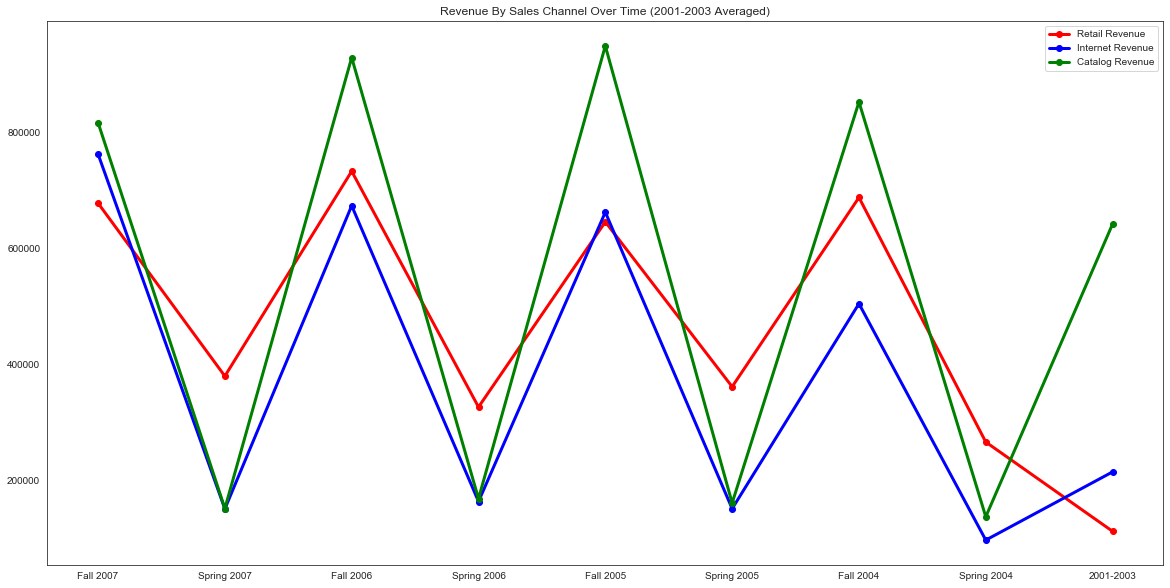

In [230]:
plt.figure(figsize = (20,10))
plt.plot( RetailTotalsOverTime.index, RetailTotalsOverTime, marker='o', color='red', linewidth=3, label="Retail Revenue")
plt.plot( InternetTotalsOverTime.index, InternetTotalsOverTime, marker='o', color='blue', linewidth=3, label="Internet Revenue")
plt.plot( CatalogTotalsOverTime.index, CatalogTotalsOverTime, marker='o', color='green', linewidth=3, label="Catalog Revenue")
plt.legend()
plt.title('Revenue By Sales Channel Over Time (2001-2003 Averaged)')

In [ ]:
print(InternetTotalsOverTime)

In [231]:
timeseriesdf = pd.DataFrame([CatalogTotalsOverTime, RetailTotalsOverTime, InternetTotalsOverTime] , index =  ['Catalog', 'Retail','Internet'])

timeseriesdf.to_csv('C:\\Users\\mznid\\Revenue Aggregate Time Series.csv')

In [114]:
#customersfeatures.to_csv('C:\\Users\\mznid\\CUSTOMERSclusteringCLV NEW.csv')

In [115]:
scaler = MinMaxScaler()
# scaler = StandardScaler()

featurenames = ['Sewing','Travel','Hunting','FineArts','CarOwner','Collect','Needle','DogOwner','Cooking','CurrAff','CurrEv','Pets','Fashion','Camping','Boating', 'Wines', 'Exercise','SelfHelp']

X = scaler.fit_transform(customersfeatures.loc[:,featurenames])

In [116]:
len(X)

82732

In [149]:
# ELBOW FOR MINMAX INITIALLY SHOWED 4

wcss = []

for k in tqdm(range(2,15)):
    kmeans = KMeans(n_clusters = k , init = 'k-means++',)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:52<00:00,  5.96s/it]


Text(0, 0.5, 'wcss: sum of dist. of sample to their closest cluster center')

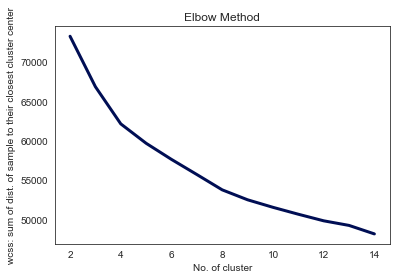

In [150]:
plt.plot(range(2,15), wcss, c = '#000E54',  linewidth = 3)
plt.title('Elbow Method')
plt.xlabel('No. of cluster')
plt.ylabel('wcss: sum of dist. of sample to their closest cluster center' )

In [118]:
kmeans_1 = KMeans(n_clusters=9)
kmeans_1.fit(X)
cluster_pred = kmeans_1.predict(X)
cluster_pred_2 = kmeans_1.labels_
cluster_center = kmeans_1.cluster_centers_

([<matplotlib.axis.XTick at 0x166c0c6f0f0>,
 <a list of 10 Text xticklabel objects>)

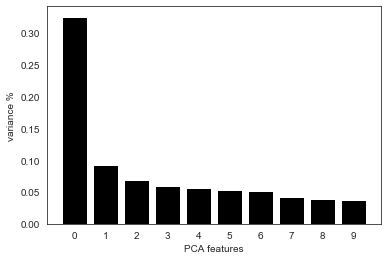

In [119]:

pca = PCA(n_components = 10)
principalComponents = pca.fit_transform(X)

pcafeatures = range(pca.n_components_)
plt.bar(pcafeatures, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(pcafeatures)


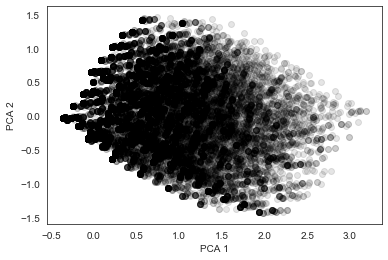

In [120]:

PCA_components = pd.DataFrame(principalComponents)

plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# TRANSFORM CENTROIDS
pcacenters = pca.transform(cluster_center)


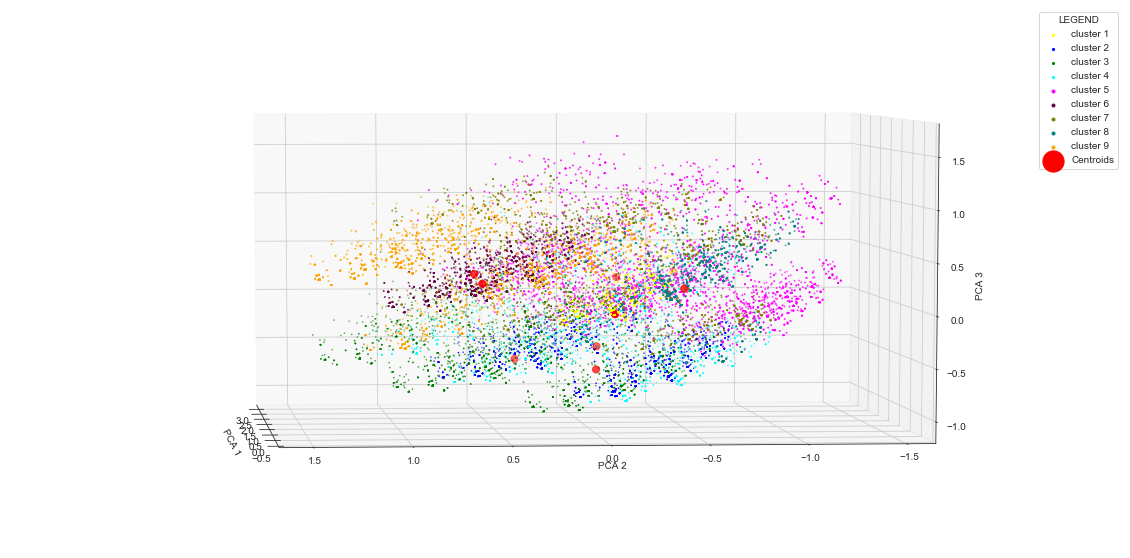

In [137]:
sns.set_style("white")
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PCA_components[0][cluster_pred==0],PCA_components[1][cluster_pred==0], PCA_components[2][cluster_pred==0], s = 0.5, c = 'yellow', label ='cluster 1' )
ax.scatter(PCA_components[0][cluster_pred==1],PCA_components[1][cluster_pred==1], PCA_components[2][cluster_pred==1], s = 0.5, c = 'blue', label ='cluster 2' )
ax.scatter(PCA_components[0][cluster_pred==2],PCA_components[1][cluster_pred==2], PCA_components[2][cluster_pred==2], s = 0.5, c = 'green', label ='cluster 3' )
ax.scatter(PCA_components[0][cluster_pred==3],PCA_components[1][cluster_pred==3], PCA_components[2][cluster_pred==3], s = 0.5, c = 'cyan', label = 'cluster 4')

ax.scatter(PCA_components[0][cluster_pred==4],PCA_components[1][cluster_pred==4], PCA_components[2][cluster_pred==4], s = 1, c = 'magenta', label = 'cluster 5')
ax.scatter(PCA_components[0][cluster_pred==5],PCA_components[1][cluster_pred==5], PCA_components[2][cluster_pred==5], s = 1, c = '#66023C', label = 'cluster 6')
ax.scatter(PCA_components[0][cluster_pred==6],PCA_components[1][cluster_pred==6], PCA_components[2][cluster_pred==6], s = 1, c = '#808000', label = 'cluster 7')
ax.scatter(PCA_components[0][cluster_pred==7],PCA_components[1][cluster_pred==7], PCA_components[2][cluster_pred==7], s = 1, c = '#008080', label = 'cluster 8')
ax.scatter(PCA_components[0][cluster_pred==8],PCA_components[1][cluster_pred==8], PCA_components[2][cluster_pred==8], s = 1, c = '#FFA500', label = 'cluster 9')


ax.scatter(pcacenters[:,0],pcacenters[:,1],pcacenters[:,2], s = 50, c = 'red', label = 'Centroids')

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel('PCA 3')
# ax.view_init(60, 110)
ax.view_init(5, 175)

plt.legend(loc='upper right', title='LEGEND', markerscale = 3)


plt.show()

In [122]:
print(np.append(np.array(customersfeatures.loc[:,['CLVestimate']]), X, axis = 1).shape)


(82732, 19)


In [ ]:
import matplotlib.colors as mcolors

Orange = '#F76900'
Blue = '#000E54'
White = '#FFFFFF'
    
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
rvb = make_colormap([c('#FFFFFF'), c('#F76900')])
N = 1000
array_dg = np.random.uniform(0, 10, size=(N, 2))
colors = np.random.uniform(-2, 2, size=(N,))
plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=rvb)
plt.colorbar()
plt.show()

Text(0.5, 16.0, 'Feature')

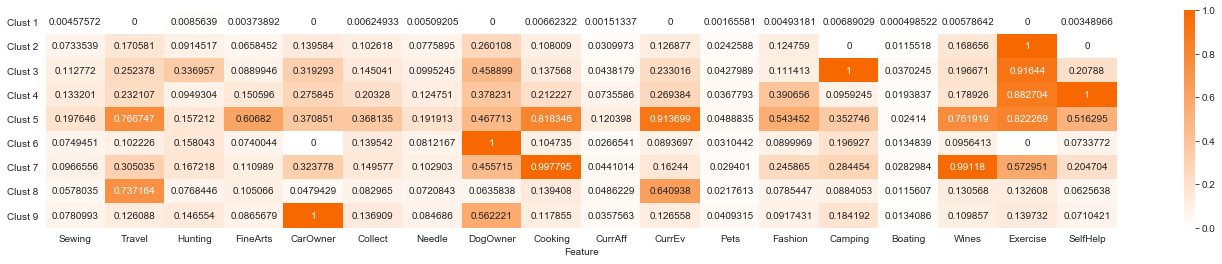

In [141]:
#featurenames = ['CLVestimate'] + featurenames
CLVnumpy  = np.array(customersfeatures.loc[:,['CLVestimate']])
clustselect = X # np.append(CLVnumpy, X, axis = 1)



cluster0 = clustselect[cluster_pred==0]
cluster1 = clustselect[cluster_pred==1]
cluster2 = clustselect[cluster_pred==2]
cluster3 = clustselect[cluster_pred==3]
cluster4 = clustselect[cluster_pred==4]
cluster5 = clustselect[cluster_pred==5]
cluster6 = clustselect[cluster_pred==6]
cluster7 = clustselect[cluster_pred==7]
cluster8 = clustselect[cluster_pred==8]


clv0 = CLVnumpy[cluster_pred==0].mean()
clv1 = CLVnumpy[cluster_pred==1].mean()
clv2 = CLVnumpy[cluster_pred==2].mean()
clv3 = CLVnumpy[cluster_pred==3].mean()
clv4 = CLVnumpy[cluster_pred==4].mean()
clv5 = CLVnumpy[cluster_pred==5].mean()
clv6 = CLVnumpy[cluster_pred==6].mean()
clv7 = CLVnumpy[cluster_pred==7].mean()
clv8 = CLVnumpy[cluster_pred==8].mean()



clusterlist = [cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8] #,cluster3,cluster4,cluster5

clusterlengths = []
for each in clusterlist:
    clusterlengths.append(len(each))

clustermeans = []
for each in clusterlist:
    clustermeans.append(np.mean(each, axis = 0))

sidebyside = pd.DataFrame(columns = customersfeatures.loc[:,featurenames].columns)
for each in clustermeans:
    sidebyside = sidebyside.append(pd.Series(each, index = customersfeatures.loc[:,featurenames].columns), ignore_index = True)   # I don't know why we have to go index-to-columns... seems counterintuitive?

sidebyside.index = ['Clust 1', 'Clust 2', 'Clust 3', 'Clust 4', 'Clust 5','Clust 6','Clust 7','Clust 8', 'Clust 9']



fig, ax = plt.subplots(figsize=(24,4)) 
sns.heatmap(sidebyside, annot = True, cmap = rvb, fmt = 'g', ax = ax,  center = 0.5) # center =      0 or 0.5   #red
plt.xlabel('Feature')
#plt.ylabel('Cluster')


Text(0.5, 16.0, 'CLV Estimate')

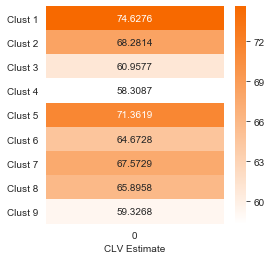

In [142]:
CLVheat = pd.DataFrame(pd.Series([clv0,clv1,clv2,clv3,clv4,clv5,clv6,clv7,clv8], index = sidebyside.index))

fig, ax = plt.subplots(figsize=(4,4)) 
sns.heatmap(CLVheat, annot = True, cmap = rvb, fmt = 'g', ax = ax)    # red
plt.xlabel('CLV Estimate')

Text(0.5, 16.0, 'Cluster Sizes')

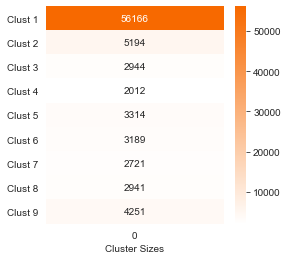

In [143]:
clustersizes = []
for each in clusterlist:
    clustersizes.append(len(each))
    
clustsize = pd.DataFrame(pd.Series(clustersizes, index = sidebyside.index))

fig, ax = plt.subplots(figsize=(4,4)) 
sns.heatmap(clustsize, annot = True, cmap = rvb, fmt = 'g', ax = ax)   # red
plt.xlabel('Cluster Sizes')    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyError: 'gpsX'

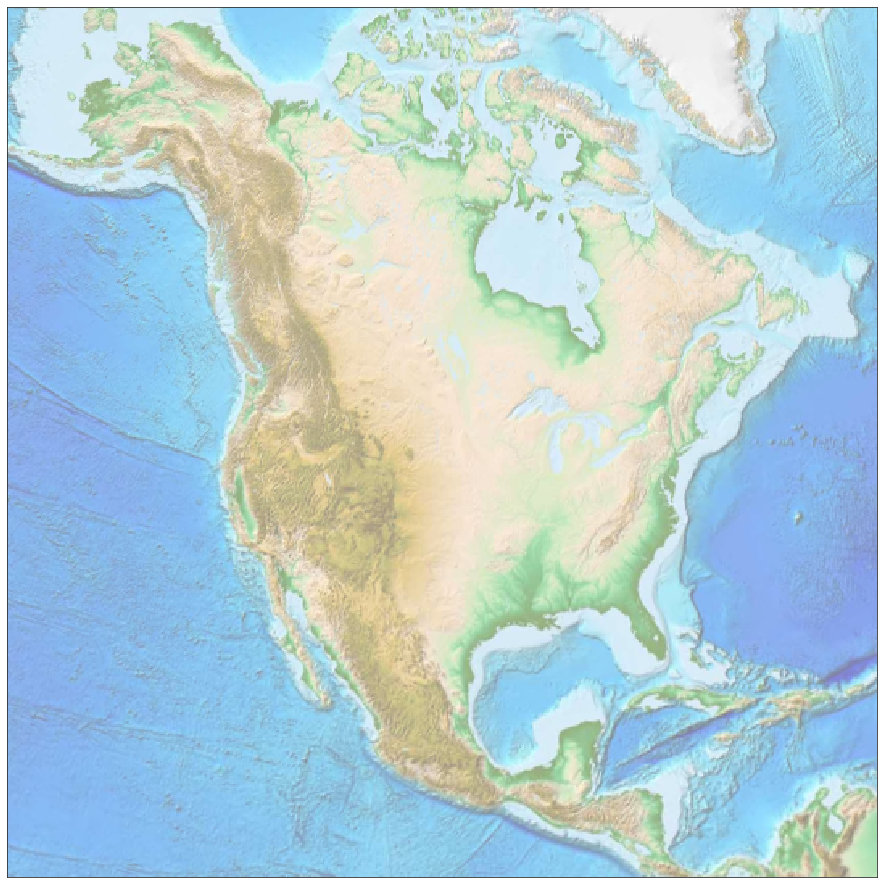

In [126]:
fig = plt.figure(figsize=(16, 16))
m = Basemap(projection='lcc', resolution=None,
            width=8E6, height=8E6, 
            lat_0=45, lon_0=-100,)
m.etopo(scale=0.5, alpha=0.5)

lat = np.array(customersfeatures.loc[:,'gpsX'])
long = np.array(customersfeatures.loc[:,'gpsY'])


def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

lat = rand_jitter(lat)
long = rand_jitter(long)


m.scatter(np.reshape(lat[cluster_pred == 0], (-1, 1)), np.reshape(long[cluster_pred == 0], (-1, 1)), latlon=True,c = 'yellow', alpha=0.5, s = 2)
m.scatter(np.reshape(lat[cluster_pred == 1], (-1, 1)), np.reshape(long[cluster_pred == 1], (-1, 1)), latlon=True,c = 'blue', alpha=0.5, s = 2)
m.scatter(np.reshape(lat[cluster_pred == 2], (-1, 1)), np.reshape(long[cluster_pred == 2], (-1, 1)), latlon=True,c = 'green', alpha=0.5, s = 2)
m.scatter(np.reshape(lat[cluster_pred == 3], (-1, 1)), np.reshape(long[cluster_pred == 3], (-1, 1)), latlon=True,c = 'cyan', alpha=0.5, s = 2)
m.scatter(np.reshape(lat[cluster_pred == 4], (-1, 1)), np.reshape(long[cluster_pred == 4], (-1, 1)), latlon=True,c = 'magenta', alpha=0.5, s = 2)
m.scatter(np.reshape(lat[cluster_pred == 5], (-1, 1)), np.reshape(long[cluster_pred == 5], (-1, 1)), latlon=True,c = '#66023C', alpha=0.5, s = 2)
m.scatter(np.reshape(lat[cluster_pred == 6], (-1, 1)), np.reshape(long[cluster_pred == 6], (-1, 1)), latlon=True,c = '#808000', alpha=0.5, s = 2)
m.scatter(np.reshape(lat[cluster_pred == 7], (-1, 1)), np.reshape(long[cluster_pred == 7], (-1, 1)), latlon=True,c = '#008080', alpha=0.5, s = 2)
m.scatter(np.reshape(lat[cluster_pred == 8], (-1, 1)), np.reshape(long[cluster_pred == 8], (-1, 1)), latlon=True,c = '#FFA500', alpha=0.5, s = 2)





In [ ]:
fig = plt.figure(figsize=(16, 16))
m = Basemap(projection='lcc', resolution=None,
            width=8E6, height=8E6, 
            lat_0=45, lon_0=-100,)
m.etopo(scale=0.5, alpha=0.5)


shuffled = customersfeatures.sample(frac=1).drop(columns = ['level_0']).reset_index()


standardizescaler = QuantileTransformer()
clvmap = standardizescaler.fit_transform(np.array(shuffled.loc[:,['CLVestimate']]))

lat = np.array(shuffled.loc[:,'gpsX'])
long = np.array(shuffled.loc[:,'gpsY'])

print(clvmap[:5])
print(np.array(shuffled.loc[:,['CLVestimate']])[:5])


def rand_jitter(arr):
    stdev = .015*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

lat = rand_jitter(lat)
long = rand_jitter(long)


m.scatter(np.reshape(lat, (-1, 1)), np.reshape(long, (-1, 1)), latlon=True,c = np.reshape(clvmap, (-1, 1)) ,cmap = 'OrRd' ,alpha=0.5, s = 3)




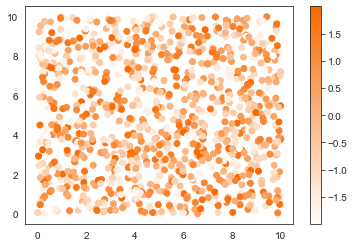